In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


## Read table
fname = 'vetting-v02'
fpath = f'../mnt/tess/labels/{fname}.csv'
all_table = pd.read_csv(fpath, header=0, low_memory=False).set_index('Astro ID')

## Rename or drop columns
all_table.drop(columns=['Split'])
all_table = all_table.rename(columns={'filename': 'File', 
                                      'Period': 'Per', 
                                      'Duration': 'Dur',
                                      'Transit_Depth': 'Depth',
                                      'star_rad': 'SRad',
                                      'star_rad_est': 'SRadEst',
                                      'star_mass': 'SMass',})

## Make label columns
disps = ['e', 'p', 'n', 'b', 't', 'u', 'j']
users = ['mk', 'ch', 'et', 'md', 'as', 'dm', 'Tansu', 'Shishir']
for d in disps:
    all_table[f'disp_{d}'] = 0

# Set all TOIs commented with "CP", "PC", or "KP" with the label 'pu'
tois_planet_mask = (all_table['comment'].str.contains("(PC)", regex=False).astype(bool) | all_table['comment'].str.contains("(CP)", regex=False).astype((bool)) | all_table['comment'].str.contains("(KP)", regex=False).astype((bool)))
# Print mismatches - not labelled planet by vetters, but is a TOI labelled KP, CP or PC (known planet, confirmed planet, planetary candidate)
print('Mismatches between TOI comment and vetting labels', all_table[tois_planet_mask][(all_table[tois_planet_mask]['Final'] != 'pt') & (~all_table[tois_planet_mask]['Final'].isna())]['TIC ID'])
all_table.loc[tois_planet_mask, 'Final'] = 'pu'


## Set labels
def set_labels(row):
    a = ~row.isna()
    if row['Final'] == 'i':
        # skip objects labeled as "inside the star"
        return row
    if a['Final']:
        row[f'disp_{row["Final"][0]}'] = 1
        row[f'disp_{row["Final"][1]}'] = 1
    else:
        for user in users:
            if a[user] and row[user]:
                row[f'disp_{row[user][0]}'] += 1
                row[f'disp_{row[user][1]}'] += 1

    return row

all_table = all_table.apply(set_labels, axis=1)


## Add more B, J, N labels from Astronet-triage into training set to J class
fpath_triage = '../mnt/tess/astronet/tces-v14-all.csv'
table_triage = pd.read_csv(fpath_triage, header=0, low_memory=False).set_index('Astro ID')

# more_Blabels = table_triage[((table_triage['disp_B'] > 0)) & (table_triage['disp_E'] == 0)].sample(1000, random_state=42)
# more_Jlabels = table_triage[((table_triage['disp_J'] > 0)) & (table_triage['disp_E'] == 0)].sample(1000, random_state=42)
# more_Nlabels = table_triage[((table_triage['disp_N'] > 0)) & (table_triage['disp_E'] == 0)].sample(500, random_state=42)
more_Blabels = table_triage[((table_triage['disp_B'] > 0)) & (table_triage['disp_E'] == 0) & (table_triage['File'].str.contains('mk_'))]
more_Jlabels = table_triage[((table_triage['disp_J'] > 0)) & (table_triage['disp_E'] == 0) & (table_triage['File'].str.contains('mk_'))].sample(1000, random_state=42)
more_Nlabels = table_triage[((table_triage['disp_N'] > 0)) & (table_triage['disp_E'] == 0) & (table_triage['File'].str.contains('mk_'))]
more_bjn_labels = pd.concat([more_Blabels, more_Jlabels, more_Nlabels])
# more_bjn_labels = more_bjn_labels.drop_duplicates()

more_bjn_labels['disp_e'] = 0
more_bjn_labels['disp_p'] = 0
more_bjn_labels['disp_n'] = 0
more_bjn_labels['disp_b'] = 0
more_bjn_labels['disp_t'] = 0
more_bjn_labels['disp_u'] = 0
more_bjn_labels['disp_j'] = 1
new_columns = all_table.keys().intersection(more_bjn_labels.keys()) # Get only overlapping columns from all_table and more_bjn_labels: Index(['TIC ID', 'Final', 'Decision', 'mk', 'ch', 'et', 'md', 'as', 'dm', 'Split', 'RA', 'Dec', 'Tmag', 'Epoc', 'Per', 'Dur', 'Depth', 'SRad', 'SMass', 'SRadEst', 'File', 'disp_e', 'disp_p', 'disp_n', 'disp_b', 'disp_t', 'disp_u', 'disp_j'])
all_table = pd.concat([all_table[new_columns], more_bjn_labels[new_columns]]) # Add 1000 Bs, 1000 Js, and 500 Ns into J class of all_table

#TODO: check why duplicate AstroIDs are in the table
print('Duplicated Astro IDs:', all_table[all_table.index.duplicated()])
all_table = all_table[~all_table.index.duplicated(keep='first')]

## Read centroid data
centroid_fpath = "compute_centroid_distance/centroid_distance_astro_ids.csv" #"../mnt/tess/labels/scoop_predictions-May2024.csv"
centroid_table = pd.read_csv(centroid_fpath, header=0, low_memory=False).set_index('Astro ID')

# ## Get minimum Centroid Distance for each Astro ID
# for astro_id in all_table.index:
#     if astro_id in centroid_table.index:
#         centroid_dist = centroid_table.loc[astro_id]['Centroid Distance (arcsec)']
#         if isinstance(centroid_dist, float):
#             min_centroid_dist = centroid_dist
#         else:
#             min_centroid_dist = min(centroid_dist)
#     else:     
#         label = all_table.loc[astro_id]['Final']
#         print(f"Astro ID {astro_id} is not in the centroid table. Label: {label}")
#         if isinstance(label, str) and len(label) == 2:
#             if label[1] == 't':
#                 min_centroid_dist = 0
#                 print('Setting centroid dist to 0 because labelled on target')
#             elif label[1] == 'b':
#                 min_centroid_dist = 100
#             else:
#                 min_centroid_dist = -1
#         else:
#             min_centroid_dist = -1

#     # # Add centroid distance to all_table
#     # all_table.loc[astro_id, 'centroid_dist'] = min_centroid_dist

#     # Remove objects with centroid distance > 20
#     if min_centroid_dist > 20 or min_centroid_dist < 0:
#         print(f"Removed Astro ID {astro_id} (TIC: {all_table.loc[astro_id]['TIC ID']}) with centroid distance {min_centroid_dist}, label: {all_table.loc[astro_id]['Final']}")
#         all_table = all_table.drop(astro_id)


## Only use labelled rows 
print(f'Total entries: {len(all_table)}')
all_table = all_table[sum(all_table[f'disp_{d}'] for d in disps) > 0]
print(f'Total labeled entries: {len(all_table)}')

## And skip bad rows that have NaN in File', 'Per', 'Dur', 'Depth', or 'Tmag'
print("Skipping these TICs:", all_table[all_table[['File', 'Per', 'Dur', 'Depth', 'Tmag']].isna().any(axis=1)]['TIC ID'])
all_table = all_table[~all_table[['File', 'Per', 'Dur', 'Depth', 'Tmag']].isna().any(axis=1)]
print(f'Total after removing rows with missing File, Per, Dur, Depth, or Tmag: {len(all_table)}')


## Train-test split
t_train, t_test = train_test_split(all_table, test_size=0.1, random_state=42)
t_train, t_val = train_test_split(t_train, test_size=1./9, random_state=42)

## Print sizes of arrays and print duplicate counts
print(f'Split sizes. Train: {len(t_train)}; Valid: {len(t_val)}; Test: {len(t_test)}')
print(f'Duplicate TICs: {len(all_table.index.values) - len(set(all_table.index.values))}')
print('Splits')
print('  train:', len(t_train))
print('  val:', len(t_val))
print('  test:', len(t_test))

## Check label arrays
assert not any((t_train['disp_e'] + t_train['disp_p']+ t_train['disp_n'] + t_train['disp_b'] + t_train['disp_t'] + t_train['disp_u'] + t_train['disp_j']) == 0)
assert not any((t_val['disp_e'] + t_val['disp_p']+ t_val['disp_n'] + t_val['disp_b'] + t_val['disp_t'] + t_val['disp_u']+ t_val['disp_j']) == 0)
assert not any((t_test['disp_e'] + t_test['disp_p']+ t_test['disp_n'] + t_test['disp_b'] + t_test['disp_t'] + t_test['disp_u'] + t_test['disp_j']) == 0)

# ## Save train, test, and validation csv files 
# NAME = "tois-triageJs-nocentroid" # [including tois as pt, including B,J,N labels from Astronet-triage, and without centroid data]
NAME = "tois-triageJs-nocentroid" # [including tois as pt, including B,J,N labels from Astronet-triage, and without centroid data, and removing TICs with centroid distance > 20 arcs]

# if os.path.exists(f'../mnt/tess/astronet/tces-{fname}-{NAME}-all.csv'):
#     print("*****\nAlready saved TCE csv files. Are you sure you want to overwrite them?\n*****")
# else:
#     pass
# t_train.to_csv(f'../mnt/tess/astronet/tces-{fname}-{NAME}-train.csv')
# t_val.to_csv(f'../mnt/tess/astronet/tces-{fname}-{NAME}-val.csv')
# t_test.to_csv(f'../mnt/tess/astronet/tces-{fname}-{NAME}-test.csv')
# all_table.to_csv(f'../mnt/tess/astronet/tces-{fname}-{NAME}-all.csv')





Mismatches between TOI comment and vetting labels Astro ID
966      300217120
1260    1551168743
1261    1551168745
1270    1716106614
1447     391925531
2017     129985650
2186     177991747
2231     192551514
2256     201180053
2261     203036357
2377     229609099
2464     240967708
2501     249925249
2504     250608111
2526     256111905
2559     264614603
2590     271443727
2600     272624139
2653     282785238
2663     285233768
2675     288855848
2905     317470446
3033     331934617
3139     348508349
3144     349572805
3169     356981097
3204     366074071
3233     373901476
3235     375716316
3236     375780380
3355     392569402
3362     394128404
3369     395938570
3395     400669188
3427     410472051
3495     428078277
3574     444725556
3576     445223944
3647     453225534
3832     640763860
3873       1260235
3879       2685481
3880       2758565
3890       4165850
3900       5224772
3914       6785559
3921       7413227
3933       8260536
3965       9907513
4028      

In [ ]:
table_triage

: 

/tmp/ipykernel_1013197/3057636265.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


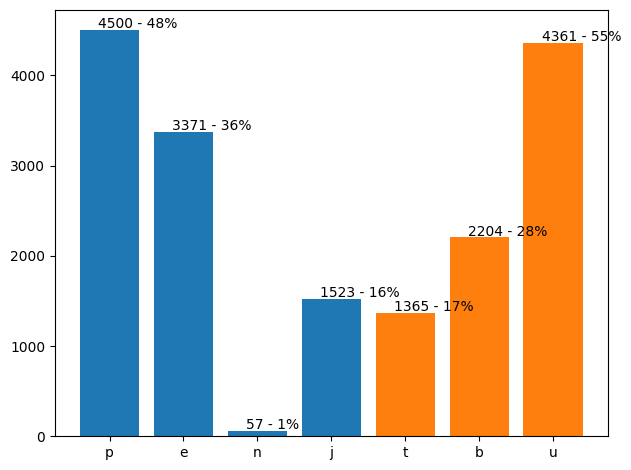

In [136]:
# Plot label distribution

from matplotlib import pyplot as plt
labels = ['p', 'e', 'n', 'j']
labels2 = ['t', 'b', 'u']

counts = [sum(all_table['disp_{}'.format(l)] > 0) for l in labels]
counts2 = [sum(all_table['disp_{}'.format(l)] > 0) for l in labels2]

plt.figure()
ax = plt.bar(labels, counts)
for i in range(len(labels)):
    b = ax[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts[i], counts[i] / sum(counts)),
        (x + 0.25, y + height + 20))
plt.tight_layout()

# plt.figure()
ax2 = plt.bar(labels2, counts2)
for i in range(len(labels2)):
    b = ax2[i]
    height = b.get_height()
    x, y = b.get_xy()
    plt.annotate(
        '{} - {:.0%}'.format(counts2[i], counts2[i] / sum(counts2)),
        (x + 0.25, y + height + 20))
plt.tight_layout()




In [137]:
all_table

,TIC ID,Final,Decision,mk,ch,et,md,as,dm,Split,...,SMass,SRadEst,File,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
Astro ID,,,,,,,,,,,,,,,,,,,,,
1,101179364,et,NaN,et,et,et,et,et,NaN,train,...,0.860,1.098840,mk_hlsp_qlp_tess_ffi-s0013-0000000101179364_te...,1,0,0,0,1,0,0
2,101255974,eb,eb,eb,eb,eb,eb,et,NaN,train,...,NaN,4.870666,mk_hlsp_qlp_tess_ffi-s0018-0000000101255974_te...,1,0,0,1,0,0,0
3,101404344,eb,eb,eb,eb,eb,eb,pb,NaN,train,...,1.540,1.728549,mk_hlsp_qlp_tess_ffi-s0027-0000000101404344_te...,1,0,0,1,0,0,0
4,101427335,et,et,et,et,et,eb,et,NaN,train,...,1.050,1.679462,mk_hlsp_qlp_tess_ffi-s0027-0000000101427335_te...,1,0,0,0,1,0,0
5,10150705,eb,eb,eb,et,eb,eb,eb,NaN,train,...,1.090,0.794777,mk_hlsp_qlp_tess_ffi-s0022-0000000010150705_te...,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28608,55369279,NaN,NaN,J,J,J,NaN,J,J,train,...,1.530,2.059285,mk_hlsp_qlp_tess_ffi-s0039-0000000055369279_te...,0,0,0,0,0,0,1
28622,5647469,NaN,NaN,J,J,J,NaN,J,J,train,...,1.140,1.191058,mk_hlsp_qlp_tess_ffi-s0036-0000000005647469_te...,0,0,0,0,0,0,1
28629,5784648,NaN,NaN,J,J,J,NaN,J,J,train,...,2.390,4.117332,mk_hlsp_qlp_tess_ffi-s0036-0000000005784648_te...,0,0,0,0,0,0,1


In [11]:
table_triage[((table_triage['disp_B'] > 0)) & (table_triage['disp_E'] == 0) & (table_triage['Final'].notna())]

,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,...,Split,Year,MaxT,MinT,File,disp_E,disp_J,disp_N,disp_S,disp_B
Astro ID,,,,,,,,,,,,,,,,,,,,,
21,119088593,B,B,B,E,B,NaN,NaN,NaN,NaN,...,train,1,1682.343934,1653.927253,tess2019247000000-0000000119088593-111-cr_llc....,0,0,0,0,1
22,143769346,B,NaN,B,B,B,NaN,NaN,NaN,NaN,...,train,1,1682.343158,1653.926401,tess2019247000000-0000000143769346-111-cr_llc....,0,0,0,0,1
24,63343395,B,B,E,B,B,NaN,NaN,NaN,NaN,...,train,1,1682.344122,1653.927462,tess2019247000000-0000000063343395-111-cr_llc....,0,0,0,0,1
46,407089973,B,NaN,B,B,B,NaN,NaN,NaN,NaN,...,test,1,1682.344736,1624.969731,tess2019247000000-0000000407089973-111-cr_llc....,0,0,0,0,1
83,350137597,B,B,B,S,J,NaN,NaN,NaN,NaN,...,val,1,1682.343679,1325.323219,tess2019247000000-0000000350137597-111-cr_llc....,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28827,82806895,B,B,NaN,NaN,J,B,J,B,J,...,train,3,2279.978590,1517.367843,mk_hlsp_qlp_tess_ffi-s0035-0000000082806895_te...,0,0,0,0,1
28858,90128622,B,B,NaN,NaN,B,E,E,E,E,...,train,3,2305.984917,1517.367453,mk_hlsp_qlp_tess_ffi-s0036-0000000090128622_te...,0,0,0,0,1
28894,92854156,B,B,NaN,NaN,B,B,B,B,B,...,train,3,2332.576910,1569.452200,mk_hlsp_qlp_tess_ffi-s0037-0000000092854156_te...,0,0,0,0,1


In [12]:
table_triage[((table_triage['disp_J'] > 0)) & (table_triage['disp_E'] == 0) & (table_triage['File'].str.contains('mk_'))]

,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,...,Split,Year,MaxT,MinT,File,disp_E,disp_J,disp_N,disp_S,disp_B
Astro ID,,,,,,,,,,,,,,,,,,,,,
26382,100325374,NaN,NaN,NaN,B,J,B,J,J,B,...,val,3,2060.640723,2036.286523,mk_hlsp_qlp_tess_ffi-s0027-0000000100325374_te...,0,3,0,0,4
26383,100757381,J,NaN,NaN,J,J,J,J,J,J,...,train,3,2227.569113,1437.992864,mk_hlsp_qlp_tess_ffi-s0033-0000000100757381_te...,0,1,0,0,0
26384,101099253,NaN,NaN,NaN,J,J,B,J,J,J,...,train,3,2169.943674,1381.721463,mk_hlsp_qlp_tess_ffi-s0031-0000000101099253_te...,0,6,0,0,1
26385,101176518,J,NaN,NaN,J,J,J,J,J,J,...,val,3,2060.640701,1653.932315,mk_hlsp_qlp_tess_ffi-s0027-0000000101176518_te...,0,1,0,0,0
26388,101434215,J,NaN,NaN,J,J,J,J,J,J,...,test,3,2279.980851,1517.369555,mk_hlsp_qlp_tess_ffi-s0035-0000000101434215_te...,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28939,99349315,J,J,NaN,NaN,J,J,J,J,J,...,train,3,2254.063155,1491.640311,mk_hlsp_qlp_tess_ffi-s0034-0000000099349315_te...,0,1,0,0,0
28940,99738392,J,NaN,NaN,NaN,J,J,J,J,J,...,train,3,2087.099563,1325.329124,mk_hlsp_qlp_tess_ffi-s0028-0000000099738392_te...,0,1,0,0,0
28941,99765092,J,NaN,NaN,NaN,J,J,J,J,J,...,train,3,2087.099576,1325.329116,mk_hlsp_qlp_tess_ffi-s0028-0000000099765092_te...,0,1,0,0,0


In [13]:
table_triage['File'].str.contains('mk_').sum()

2562

In [14]:
fpath_triage = '../mnt/tess/astronet/tces-v14-all.csv'
table_triage = pd.read_csv(fpath_triage, header=0, low_memory=False).set_index('Astro ID')

In [15]:
for fname in table_triage['File'][((table_triage['disp_J'] >= 0)) & (table_triage['File'].str.contains('mk_'))]:
    print(os.path.exists(f'../mnt/tess/lc_vetting_and_triage_symbolic_links/{fname}'), fname)

True mk_hlsp_qlp_tess_ffi-s0027-0000000100325374_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000100757381_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000101099253_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101176518_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101232323_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000101385848_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0035-0000000101434215_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101455096_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000101496204_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000101905676_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101910895_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000101946403_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000101964513_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000102062770_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000102208119_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0033-0000000124383072_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000012472275_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000124774218_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000124944172_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000125190002_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000001254504863_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000012631328_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000012632558_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000126762761_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000012685906_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000126913435_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000126944775_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000127097876_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000128212258_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000129115637_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0037-0000000144154961_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000144165514_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144193333_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144216017_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144216851_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000144225591_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144251856_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000144331452_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000144384638_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000144386996_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144443966_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000144444811_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000144449373_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000144459267_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000144460931_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0034-0000000157046364_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000157116410_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000157313676_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000157396910_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000157774965_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000157787615_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000158069530_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000158331041_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000158499558_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000158646549_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000158904179_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000001595346_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000159638137_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000159732516_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000159734992_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0036-0000000193272753_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000193840344_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000019515573_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0035-0000000019681005_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197590350_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197590496_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197613984_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197614589_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197616908_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197643940_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197682658_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197687340_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197695249_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197695641_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000197732532_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0028-0000000211408248_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000211409161_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000211409752_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000211409944_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000211433060_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000211441476_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000212377300_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000213033299_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000213841827_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000214061403_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000214300025_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000214301032_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000214426233_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000214426920_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000214515903_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0033-0000000235382434_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237310485_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237311777_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237313342_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237317141_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237321052_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237323211_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237327080_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000237336121_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000237826881_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000237849622_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000237914675_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000237922090_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000237927802_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000237944314_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0039-0000000262652975_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000262721265_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000262789653_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000262816684_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000262818237_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000262837838_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000262837943_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000262873725_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000262883967_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000262898188_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000262929713_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000263015893_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000263076386_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000263078264_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000263183912_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0031-0000000279484406_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000279537689_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000279572957_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000279618060_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000279643499_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000279647620_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000027973728_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000279740818_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000279854361_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000280001951_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000028001433_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000280095777_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000280506453_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000280793884_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000280830936_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0039-0000000300932792_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000301247533_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000030127548_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000301342903_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000301343785_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000301376799_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000301378203_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000301548420_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000301793286_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000302027229_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000302028207_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000302041464_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000302283699_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000302334129_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000302490600_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0033-0000000033990856_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000033992223_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000340319337_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0031-0000000034113300_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000341386626_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000034140673_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000341847773_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000342073807_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000342208067_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000342680077_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000034272665_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000342751428_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000343449712_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000343584628_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000343722184_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0039-0000000402471941_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000402721692_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000402726467_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000040280774_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000402945769_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000403083808_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000403207877_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000403208586_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000403266503_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000403283728_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000403317706_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000403565092_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000404449538_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000404931181_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000404972718_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0039-0000000453095683_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000453259099_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000453336433_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000453484274_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000453498851_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000454140642_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000454144573_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000454148037_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000454153657_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000454291762_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0038-0000000454340599_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000454422400_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000454534617_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0039-0000000454718065_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000045492395_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0028-0000000053724519_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053725417_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000053744519_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053750844_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053783180_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053812406_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053812479_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053815003_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053840033_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053853066_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053853190_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053895588_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053895723_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053939444_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000053950487_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0028-0000000070448692_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000070490240_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0035-0000000070511571_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000070554272_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000070555442_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000070577786_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000706045817_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0035-0000000070625106_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000070858145_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000070887357_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000070987067_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000071011547_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000071036156_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0036-0000000071222593_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000071273195_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0030-0000000091594940_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000091595611_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000091641928_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0029-0000000092135115_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000092155735_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000092156288_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0030-0000000092192227_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092446981_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092452317_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092563795_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0037-0000000009257397_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092625873_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092628802_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092630931_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000092654959_tess_v01_llc.

In [16]:
# fnames = []
# exists = []
# for fname in all_table['File']:
#     exist = os.path.exists(f'../mnt/tess/lc_vetting_and_triage_symbolic_links/{fname}')
#     fnames.append(fname)
#     exists.append(exist)
#     print(exist, fname)
        

True mk_hlsp_qlp_tess_ffi-s0013-0000000101179364_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000101255974_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101404344_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101427335_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000010150705_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000101513965_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000101546875_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000101547609_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000101675455_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000101695924_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000102731164_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000103573024_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000103657171_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000104914008_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0023-0000000105618511_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0016-0000000137778682_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000138017750_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000138032974_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000013828577_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000138505004_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000138588540_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000138618351_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000138650903_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000138819293_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000139079180_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000139144054_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000140892243_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000141148940_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000141685465_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000141809360_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0013-0000000056773241_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000057919833_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000058108085_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000058553534_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000061329361_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000061381436_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000061615041_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000061615109_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000061794497_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000061802871_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000062090970_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000062491518_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000062493628_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000063095911_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000063097440_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0013-0000000089496702_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000089564762_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000089575652_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000089577845_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000089662511_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000089748395_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000089904680_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090083037_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090086266_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090088601_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090104045_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090239533_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090566043_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000090580320_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000090730706_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0017-0000000176854066_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000176860064_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000177077475_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000177239203_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000177285916_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000177417406_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000177823340_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000180412528_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000180416826_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0023-0000000180570279_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0023-0000000180652891_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000180761818_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000180770456_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000181233908_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000181341926_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0019-0000000239714064_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000239746556_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000240277644_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000240291153_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000240319271_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000240460949_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000240502860_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000240865015_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000240889942_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000240897200_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000240959477_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000240992272_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000241124203_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000242700892_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0024-0000000243248327_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0034-0000000271905978_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000271975434_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272178884_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272181655_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272364793_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272368236_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272489043_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000272650576_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000272783172_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000273308789_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000273697554_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000273758462_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000273941203_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000274161343_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000274171474_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0013-0000000294765664_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000294871044_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000294890615_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295125030_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295125033_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295167241_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295169431_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295174363_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000295296524_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000295302063_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295313132_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000295541511_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000296012680_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000297032911_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000298309266_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0018-0000000312555100_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000312678993_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000312758663_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000313030085_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000314163397_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000314865962_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000314887863_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000315728717_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000315765488_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000316045916_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000316840393_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000317018306_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000317264215_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000317888368_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000318019844_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0019-0000000347995170_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000348314199_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000348517784_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000348770361_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000348839628_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000348843066_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000348997611_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000349246232_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000349344436_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000349429641_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000349539672_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000349571436_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000349643889_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000349789882_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000349827430_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0023-0000000368129261_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000368332050_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000368435330_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000369255529_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000369327648_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000369770419_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000369816679_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000369860950_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000369958563_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000370015361_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000370108711_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0018-0000000370759597_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000371513482_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000371839073_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000371839648_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0027-0000000390996644_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000391001489_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000391173252_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000391745591_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000391812839_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000391923274_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000392180516_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000392483505_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000392536805_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000393578740_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000393876901_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000393894013_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000394232334_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0028-0000000394233060_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000394512189_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0027-0000000419744996_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000419865067_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000419924650_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000420115946_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000420116962_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000420215263_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000420957957_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000421154783_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000421262493_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000421894914_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000422746188_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000423237407_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0027-0000000423266608_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000424565534_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0023-0000000424719589_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0021-0000000841030789_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000900158020_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000900158021_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000900206636_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000950676499_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000000010489_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000000105400_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000000158580_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000002106313_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000002229921_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000003658835_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000007474623_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000009989136_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000010024403_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000011111899_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0011-0000000060768924_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000061599893_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000063199675_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000064265973_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000064325220_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000064403516_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000064948515_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000064982439_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000066172548_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000066288793_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000066445643_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0010-0000000066754047_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0010-0000000066755953_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000067027448_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000067309890_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0012-0000000141281260_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000141334793_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000141432199_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000141663460_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000141663464_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000141670822_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000141714083_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000141806598_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000142243067_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000142308083_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000142320454_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000142381532_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000142513212_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000142878493_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000142946724_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0007-0000000173510717_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000173814550_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000174291112_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000174418699_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000175619757_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000175953479_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000176463726_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000176711831_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000177077475_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000178006418_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000179028588_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000179040880_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000179097087_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000179131705_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000179252989_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0012-0000000214416183_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000214533332_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000214728964_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000214981577_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000215319726_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000215860874_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216122841_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216136608_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216149295_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216165538_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216419363_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216419371_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216419562_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216795080_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000216871994_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0012-0000000238198708_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000238226142_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0032-0000000238228073_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000238543760_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000238616135_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000238616144_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000238670552_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000239187299_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000239278684_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000239715814_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000239814191_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000239816243_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000239834405_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000240118419_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000240121930_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0011-0000000271175883_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000271230204_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000271295765_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000271351104_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000271541947_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000271697430_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000271903247_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000272050287_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000272284162_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000272364191_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000272368236_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000272397120_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000272462761_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000272635712_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0026-0000000272783172_tess_v0

True mk_hlsp_qlp_tess_ffi-s0011-0000000299798694_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000300140870_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000300169440_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000300234002_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000300272165_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0033-0000000300291839_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000300380793_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000300448520_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000300561691_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000300740521_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0007-0000000300808301_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0034-0000000300871545_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000301250702_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000302038263_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0010-0000000303123055_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0011-0000000312447774_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000312576659_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000312594037_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000312594950_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000312909996_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000312934382_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313051040_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313079610_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000313109078_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313265560_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313440720_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000313506360_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313656309_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313669529_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000313672833_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0011-0000000328984640_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000329017301_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329119931_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329119936_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329158471_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000329170722_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329354989_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329541465_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329544652_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329656666_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000329684465_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000329694340_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000330113590_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000330210666_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000330223440_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0014-0000000352583767_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000353140072_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0016-0000000353216109_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0015-0000000353448002_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0022-0000000353778788_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0021-0000000353934350_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000353988095_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000354006740_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000354274143_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0019-0000000355569809_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000356473029_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000356590734_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000356639350_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000356747847_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0014-0000000357047077_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0012-0000000382259605_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382288998_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382291887_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0003-0000000382302241_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382400632_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382438480_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000382446393_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382744087_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382851553_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000382945008_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000382986366_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000383109671_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000383236314_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0013-0000000383594341_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000383716496_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0023-0000000409369549_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000409520860_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000409764819_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000409840799_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000410439376_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000410712205_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000411531959_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0017-0000000411582260_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000411595102_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000412330557_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000412377174_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000412377282_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000412471212_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000412542159_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000412612669_tess_v01_llc.

True mk_hlsp_qlp_tess_ffi-s0011-0000000454643296_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000454747287_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455311320_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455318073_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455374178_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455387814_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455389013_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455416026_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000455481912_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000455667423_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0012-0000000456058602_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0020-0000000456235787_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000457455011_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0011-0000000457462086_tess_v01_llc.fits
True mk_hlsp_qlp_tess_ffi-s0010-0000000457544563_tess_v01_llc.

True astronet_hlsp_qlp_tess_ffi-s0064-0000000000160023_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000000808243_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000000857186_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000000909930_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001003831_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001018843_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001103432_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001122079_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001129033_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001133072_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001260235_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001449640_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001525480_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000001528

True astronet_hlsp_qlp_tess_ffi-s0064-0000000012036590_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000012061971_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000012421862_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000012862099_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000012980264_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013021029_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013023378_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013023738_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013349647_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013419950_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013424053_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013533330_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013574009_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000013684

True astronet_hlsp_qlp_tess_ffi-s0064-0000000023179035_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000023229805_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000023435610_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000023725901_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000023937608_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000023982469_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024113219_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024358417_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024615998_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024695044_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024833662_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000024837152_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000025155310_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000025212

True astronet_hlsp_qlp_tess_ffi-s0064-0000000034980970_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035009898_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035022727_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035106764_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035285308_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035315453_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035483319_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035516889_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035582553_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035636165_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035652085_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035758536_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035855047_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000035857

True astronet_hlsp_qlp_tess_ffi-s0064-0000000048274889_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000048476907_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000048476908_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000048661942_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000048806546_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049043968_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049045066_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049046332_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049066806_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049254857_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049428710_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000049705089_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000050312495_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000050379

True astronet_hlsp_qlp_tess_ffi-s0064-0000000064071894_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000064282927_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000064938667_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065212867_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065412605_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065416038_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065440953_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065446983_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065737977_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065805840_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065845738_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065905621_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065949719_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000065981

True astronet_hlsp_qlp_tess_ffi-s0064-0000000076663549_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000076798849_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000076882795_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000076894548_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000076923707_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077031414_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077044471_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077156657_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077156829_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077258279_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077527511_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077550515_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077680373_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000077958

True astronet_hlsp_qlp_tess_ffi-s0064-0000000092992033_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000093093765_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000093862917_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000094011343_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000094346376_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000094405787_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000094823134_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000094986319_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095010343_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095079513_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095191643_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095234976_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095337971_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000095361

True astronet_hlsp_qlp_tess_ffi-s0064-0000000106224627_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000106402532_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000106626059_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000106829921_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000106940971_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107017977_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107018378_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107090327_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107340585_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107440797_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107506563_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107617930_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107776260_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000107782

True astronet_hlsp_qlp_tess_ffi-s0064-0000000123495874_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000123627908_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000123702439_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000123846039_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124029677_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124095888_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124146529_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124174267_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124206468_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124235800_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124322274_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124379043_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124453339_tess_v01_llc.fits
True astronet_hlsp_qlp_tess_ffi-s0064-0000000124454

KeyboardInterrupt: 

In [17]:
np.any(~np.array(exists))

False

In [18]:
more_bjn_labels

,TIC ID,Final,Decision,av,md,ch,as,mk,et,dm,...,disp_N,disp_S,disp_B,disp_e,disp_p,disp_n,disp_b,disp_t,disp_u,disp_j
Astro ID,,,,,,,,,,,,,,,,,,,,,
26382,100325374,NaN,NaN,NaN,B,J,B,J,J,B,...,0,0,4,0,0,0,0,0,0,1
26384,101099253,NaN,NaN,NaN,J,J,B,J,J,J,...,0,0,1,0,0,0,0,0,0,1
26386,101232323,B,B,NaN,B,J,E,B,B,B,...,0,0,1,0,0,0,0,0,0,1
26395,102062770,NaN,NaN,NaN,B,J,B,J,J,B,...,0,0,4,0,0,0,0,0,0,1
26396,102208119,NaN,NaN,NaN,B,J,B,J,J,B,...,0,0,3,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28824,82109064,NaN,NaN,NaN,NaN,J,N,J,J,J,...,1,0,0,0,0,0,0,0,0,1
28870,91641928,NaN,NaN,NaN,NaN,J,J,J,J,J,...,1,0,0,0,0,0,0,0,0,1
28871,92135115,NaN,NaN,NaN,NaN,J,J,J,J,N,...,1,0,0,0,0,0,0,0,0,1


In [19]:
all_table.keys()


Index(['TIC ID', 'Final', 'Decision', 'mk', 'ch', 'et', 'md', 'as', 'dm',
       'Split', 'RA', 'Dec', 'Tmag', 'Epoc', 'Per', 'Dur', 'Depth', 'SRad',
       'SMass', 'SRadEst', 'File', 'disp_e', 'disp_p', 'disp_n', 'disp_b',
       'disp_t', 'disp_u', 'disp_j'],
      dtype='object')

In [20]:
pd.read_csv('/pdo/users/dmuth/Astronet-Triage/compute_centroid_distance/centroid_distance_astro_ids.csv', header=0, low_memory=False).set_index('Astro ID')

,TIC ID,Sector,Centroid Distance (arcsec),PRF Fit Quality,Optim Method
Astro ID,,,,,
1,101179364,13,2.027921,0.962476,L-BFGS-B
1,101179364,27,0.679082,0.995464,L-BFGS-B
1,101179364,67,0.731146,0.996183,L-BFGS-B
2,101255974,18,23.282496,0.998133,L-BFGS-B
2,101255974,42,22.494091,0.999285,L-BFGS-B
...,...,...,...,...,...
28629,5784648,8,1.137269,0.869838,L-BFGS-B
28629,5784648,36,18.060635,0.712176,L-BFGS-B
28629,5784648,62,7.484175,0.429319,L-BFGS-B


In [21]:
periods = np.copy(all_table['Per'])

Text(0, 0.5, 'Number of Objects')

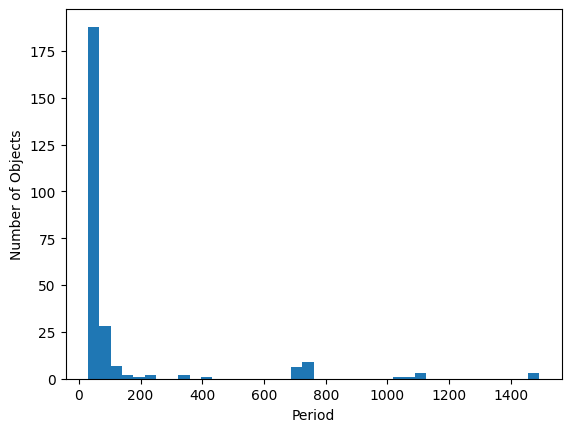

In [22]:
# for i, p in enumerate(periods):
#     if p > 100:
#         periods[i] = 100
plt.hist(periods[periods>30], bins=40)
plt.xlabel('Period')
plt.ylabel('Number of Objects')

In [23]:
sum(periods>1500)

0

Text(0, 0.5, 'Number of Objects')

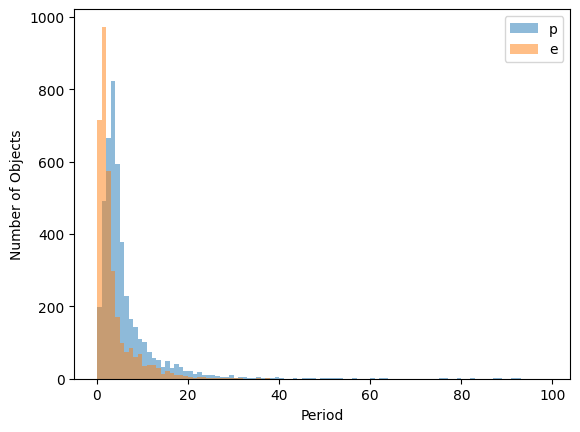

In [24]:
masklt100 = all_table['Per'] < 100
plt.hist(all_table['Per'][masklt100][all_table['disp_p'][masklt100] > 0], bins=np.arange(0,100), alpha=0.5, label='p')
plt.hist(all_table['Per'][all_table['disp_e'] > 0], bins=np.arange(0,40), alpha=0.5, label='e')
plt.legend()
plt.xlabel('Period')
plt.ylabel('Number of Objects')

In [25]:
fname = 'vetting-v02'
fpath = f'../mnt/tess/labels/{fname}.csv'
all_table = pd.read_csv(fpath, header=0, low_memory=False).set_index('Astro ID')

In [26]:
for i in all_table[all_table['Per'] > 30]['Final']:
    if not isinstance(i, str) and not i == '':
        print(i)
        


KeyError: 'Per'

In [ ]:
(all_table[all_table['Per'] > 30][['TIC ID', 'disp_p', 'disp_j']]['disp_p'] == 0) & (all_table[all_table['Per'] > 30][['TIC ID', 'disp_p', 'disp_j']]['disp_e'] > 0) & (all_table[all_table['Per'] > 30][['TIC ID', 'disp_p', 'disp_j']]['disp_j'] > 0)

In [27]:
centroid_fpath = "compute_centroid_distance/centroid_distance_astro_ids.csv" #"../mnt/tess/labels/scoop_predictions-May2024.csv"
centroid_table = pd.read_csv(centroid_fpath, header=0, low_memory=False).set_index('Astro ID')


In [74]:
# Save some centroid images who's ontarget labels don't match with their centroid distances

tics_to_save = [] 
counter = 0
for astro_id in all_table.index:
#     if astro_id in centroid_table.index and all_table.loc[astro_id]['disp_t'] > 0:
    if (astro_id in centroid_table.index) and (all_table.loc[astro_id]['disp_b'] > 0) and (all_table.loc[astro_id]['disp_t'] == 0):
        centroid_dist = centroid_table.loc[astro_id]['Centroid Distance (arcsec)']
        if isinstance(centroid_dist, float):
            min_centroid_dist = centroid_dist
        else:
            min_centroid_dist = min(centroid_dist)
        if min_centroid_dist < 20:
            print(astro_id, all_table.loc[astro_id]['TIC ID'], min_centroid_dist)
            tics_to_save.append(all_table.loc[astro_id]['TIC ID'])
            counter += 1

print("Number of TICs", counter)
        

5 10150705 9.24026985762577
10 101695924 16.868819144378936
11 102731164 12.588878564366672
16 106013773 15.454684208232903
28 112827315 0.3828976092401371
40 11469974 6.413888737620265
41 115064173 6.788228645015544
49 116681081 9.302302132044831
50 116724157 17.524552253677488
51 116727724 15.134307480495206
55 117289683 6.382658941815191
59 117453686 6.395887727328985
65 118274531 4.429858223320594
70 118399541 9.49020301051371
77 119153127 12.611148790024572
88 120199940 12.308815530107282
110 127836129 8.277757729077358
120 129539786 13.590892538943166
125 135789669 17.193763266468363
128 136462655 14.213056339072676
153 142748406 0.9278684844270556
154 142963071 4.722200316860518
161 143803539 16.33724094716742
186 21249791 12.630555615915394
192 21780369 11.464773058348632
195 22306932 4.852786648921727
213 23826331 10.041633763027734
224 27776350 11.007584754584595
229 28329552 17.166381230092725
232 28690049 13.11617751262968
237 30275619 3.996777901744448
239 30471979 8.02911

1965 122355918 16.22524334304678
1970 122707747 15.461601742925687
1972 122897814 8.519364813558282
1980 124780430 10.932652035281553
1983 125618950 14.393686058533254
1989 126309829 13.211180638297122
1997 127602771 4.768976758717779
2000 127836129 8.277757729077358
2003 128005970 10.9933859097144
2009 129058686 4.262068124593935
2012 129191367 19.968577633728664
2021 136209118 14.781821413902335
2026 136973976 12.612353309376893
2030 138167103 18.61883073623563
2031 138287408 12.921104167876049
2032 138361973 4.274113215690962
2037 139252264 3.514120419868952
2038 139395122 17.52840559594306
2040 139644924 13.474875407672195
2041 140595903 5.302623779343029
2049 141334793 1.280669418217493
2070 146177060 5.608769985367979
2075 147925015 10.92004531084036
2079 148307820 5.637994912348852
2085 152899036 17.291514756339488
2086 153227267 18.97628559927931
2089 154211529 3.9750189176026143
2091 154396581 3.833323776586254
2098 157776139 13.9532050882853
2102 158490401 7.331699335286296
2

3529 439617770 6.198214673770752
3532 440186521 8.890609360233288
3536 440520741 15.96817333282893
3537 440607377 19.39553742361857
3539 440710516 19.209825356457223
3545 440932830 10.981179455507789
3550 441773651 6.860709409489043
3554 441875362 18.40824814332472
3557 442382301 9.688673172285142
3561 442727960 4.821367423005825
3565 442899616 18.454170818662806
3566 442908230 4.563317092869779
3569 443102233 14.650993303576865
3575 444911333 14.321597613241622
3577 445648583 9.943578535482349
3578 445903569 0.6329352809251385
3580 446463870 2.714049265523901
3582 446916793 7.47141515106785
3587 448140384 3.3919203085587277
3589 448419342 19.31464308305335
3592 448650100 9.25398763286766
3593 448719936 18.16978030762409
3594 448816348 15.092327480618508
3597 449356205 16.49241268681708
3598 449379391 13.21641885939028
3607 450200861 16.360296130180927
3611 450368173 14.476805020540024
3612 450395029 6.333697983742201
3613 450457660 16.528099807962377
3614 450559047 9.270101673440228
3

In [75]:
# # Copy files
# import shutil
# import glob

# # !mkdir "/pdo/users/dmuth/Astronet-Triage/compute_centroid_distance/download_example_centroid_imgs/labelled_b_but_small_centroiddist"

# for tic in tics_to_save:
#     dst = "/pdo/users/dmuth/Astronet-Triage/compute_centroid_distance/download_example_centroid_imgs/labelled_b_but_small_centroiddist"
#     for src in glob.glob(f"/pdo/users/dmuth/Astronet-Triage/compute_centroid_distance/tic-images/tic{tic}/diffImage*.png"):
#         shutil.copy(src, dst)

flatpak: symbol lookup error: /lib64/libldap.so.2: undefined symbol: EVP_md2, version OPENSSL_3.0.0
setup-pdo.sh has already been run.


KeyboardInterrupt: 

In [ ]:
all_table.loc[astro_id]['disp_t'] > 0

In [52]:
! ls /pdo/users/dmuth/Astronet-Triage/compute_centroid_distance/download_example_centroid_imgs/

flatpak: symbol lookup error: /lib64/libldap.so.2: undefined symbol: EVP_md2, version OPENSSL_3.0.0
setup-pdo.sh has already been run.


In [24]:
np.where(all_table['centroid_dist'].isnull())

(array([6700, 7664, 8554, 8578, 8608, 8628, 8636, 8645, 8735, 8744, 8768,
        8772, 8797, 8820, 8839, 8840, 8869, 8905, 8913, 8968, 9005, 9011,
        9032, 9035, 9057, 9066, 9111, 9114, 9115, 9132, 9174, 9182, 9256,
        9389]),)

Text(0, 0.5, 'Labelled j')

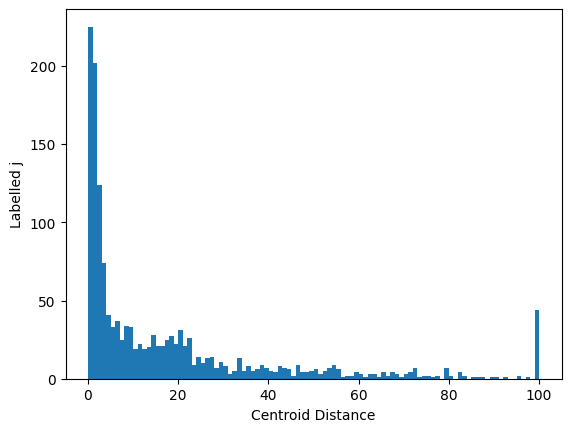

In [53]:
# Get distribution of centroid distances for each label

histvalues = np.copy(all_table['centroid_dist'][all_table['disp_j'] > 0])
histvalues[histvalues > 100] = 100
plt.hist(histvalues, bins=100)
plt.xlabel('Centroid Distance')
plt.ylabel("Labelled j")

(array([  2.,   0.,   2.,   4.,   0.,   1.,   0.,   3.,   1.,   3.,   4.,
          4.,   9.,   4.,   5.,   8.,   2.,  11.,   8.,   8.,   9.,  12.,
         13.,  18.,  15.,  34.,  38.,  33.,  55.,  55.,  70.,  64.,  78.,
         55.,  78.,  80.,  74.,  76.,  64.,  94.,  94.,  85.,  71., 103.,
         85.,  81.,  87.,  88., 106., 102., 104., 117., 130.,  94.,  90.,
        115., 110., 122., 117., 112., 103., 117., 110., 116., 128., 121.,
        143., 161., 166., 160., 190., 199., 190., 199., 162., 163., 189.,
        176., 178., 173., 154., 171., 170., 157., 159., 136., 166., 142.,
        149., 127., 127., 161., 104., 137., 133., 112., 132., 128., 121.,
        126., 112., 124., 109., 120., 102., 128., 102., 118.,  98.,  78.,
        108., 104.,  96.,  86.,  87.,  83.,  93.,  66.,  79.,  76.,  73.,
         66.,  85.,  76.,  67.,  65.,  58.,  66.,  64.,  57.,  70.,  66.,
         53.,  55.,  62.,  54.,  47.,  52.,  54.,  51.,  44.,  60.,  58.,
         45.,  54.,  46.,  47.,  56., 

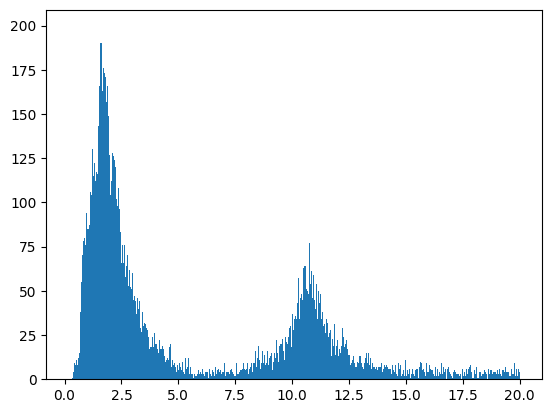

In [131]:
plt.hist(table_triage['SRad'][table_triage['SRad'] < 20], bins=1000)

In [62]:
all_table.loc[1]

TIC ID                                                   101179364
Final                                                           et
Decision                                                       NaN
mk                                                              et
ch                                                              et
et                                                              et
md                                                              et
as                                                              et
dm                                                             NaN
Split                                                        train
RA                                                      299.150851
Dec                                                     -52.312946
Tmag                                                        11.505
Epoc                                                   1654.097539
Per                                                       1.48

In [115]:
all_table['Planet-Radius'] = np.sqrt((all_table['Depth'] / 1e6)) * all_table['SRad'] * 109.2

all_table['label_type'] = None
all_table['label_onoff'] = None
all_table['label_type'][all_table['disp_j'] > 0] = 'J'
all_table['label_type'][all_table['disp_e'] > 0] = 'E'
all_table['label_type'][all_table['disp_p'] > 0] = 'P'
all_table['label_onoff'][all_table['disp_j'] > 0] = 'J'
all_table['label_onoff'][all_table['disp_b'] > 0] = 'b'
all_table['label_onoff'][all_table['disp_t'] > 0] = 't'

/tmp/ipykernel_1013197/1289749962.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_table['label_type'][all_table['disp_j'] > 0] = 'J'
/tmp/ipykernel_1013197/1289749962.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_table['label_type'][all_table['disp_e'] > 0] = 'E'
/tmp/ipykernel_1013197/1289749962.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_table['label_type'][all_table['disp_p'] > 0] = 'P'
/tmp/ipykernel_1

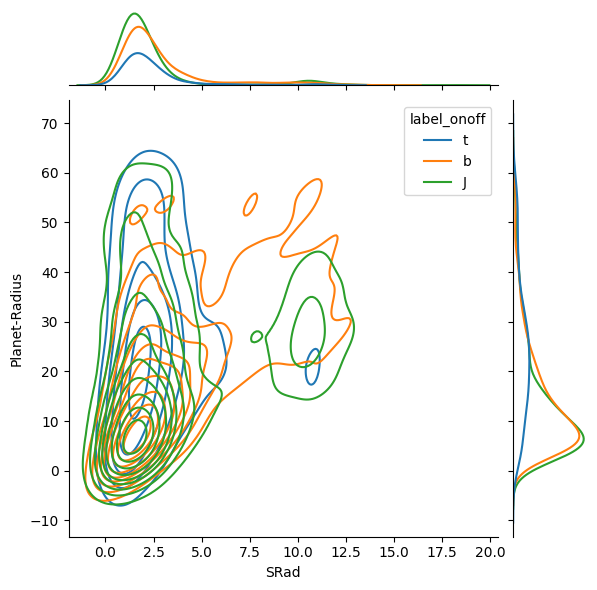

In [128]:
# import seaborn as sns
g = sns.jointplot(data=all_table[(all_table['SRad'] < 20) & (all_table['Planet-Radius'] < 60)], x='SRad', y='Planet-Radius', kind='kde', hue='label_onoff')
# g.plot_marginals(sns.boxplot)

Astro ID
1        E
2        E
3        E
4        E
5        E
        ..
28608    J
28622    J
28629    J
28738    J
28878    J
Name: label_type, Length: 9390, dtype: object